In [1]:
from astropy.table import Table, join, hstack, unique
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import requests

In [2]:
mpl.rc('font', size=12)
#mpl.rc('axes', titlesize='small')
mpl.rc('figure', max_open_warning=0)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [62]:
galaxies = SkyCoord(ra=galaxy_table['RA']*u.degree, dec=galaxy_table['DEC']*u.degree)
alfalfa = SkyCoord(ra=alfalfa_table['RAdeg_OC']*u.degree, dec=alfalfa_table['DECdeg_OC']*u.degree)

matches, ang_sep, dist3d = galaxies.match_to_catalog_sky(alfalfa)
sga_ids = []
matched_alfalfa = []

for i in range(len(galaxy_table)):
    
    if ang_sep[i].to(u.arcsec) <= 60.*u.arcsec:
        sga_ids.append(galaxy_table['SGA_ID'][i])
        matched_alfalfa.append(matches[i])

In [63]:
len(np.unique(sga_ids))

120

In [64]:
len(np.unique(matched_alfalfa))

120

In [65]:
isgalaxy = [idx for idx in range(len(galaxy_table)) if galaxy_table['SGA_ID'][idx] in np.unique(sga_ids)]
galaxy_targets = galaxy_table[isgalaxy]

In [66]:
alfalfa_targets = alfalfa_table[matched_alfalfa]

In [67]:
tab = hstack([galaxy_targets, alfalfa_targets])

In [68]:
tab.write('cache/Cosmicflows4_HI_comparison_table.fits', format = 'fits', overwrite = True)

## Using Cosmicflows-4 corrected data
Dervied from the $W_{M50}$ values obtained from ALFALFA

In [3]:
CF_table = Table.read('cache/Cosmicflows4TFR.txt', format = 'ascii')

In [4]:
CF_table[:2]

PGC,Name,Inc,e_Inc,HRV,Wmx,e_Wmx,logWmxi,e_logWmxi,m21,e_m21,umag,gmag,rmag,imag,zmag,W1mag,W2mag,(b/a)s,(b/a)W,Reu,Reg,Rer,Rei,Rez,ReW1,ReW2,ucmag,gcmag,rcmag,icmag,zcmag,W1cmag,W2cmag,Au,e_Au,Ag,e_Ag,Ar,e_Ar,Ai,e_Ai,Az,e_Az,AW1,e_AW1,AW2,e_AW2,u*mag,g*mag,r*mag,i*mag,z*mag,W1*mag,W2*mag,pW2*mag,Gu,Gg,Gr,Gi,Gz,Gw1,Gw2,pGu,pGg,pGr,pGi,pGz,pGW1,pGW2,pA-u,pA-g,pA-r,pA-i,pA-z,pA-W1,pA-W2,P1-W2,e_P1-W2,P1-pW2,P1-W1,QSflag,QWflag,Rsrc
,,deg,deg,km / s,km / s,km / s,dex(km / s),dex(km / s),mag,mag,mag,mag,mag,mag,mag,mag,mag,,,arcmin,arcmin,arcmin,arcmin,arcmin,arcmin,arcmin,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,
int64,str25,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
2,UGC12889,52,4,5004,437,16,2.744,0.029,15.713,0.185,--,--,--,--,--,11.86,12.49,--,0.66,--,--,--,--,--,0.51,0.51,--,--,--,--,--,11.9,12.53,--,--,--,--,--,--,--,--,--,--,0.01,0.0,0.01,0.0,--,--,--,--,--,11.89,12.52,12.53,1.06,0.7,0.51,0.37,0.2,0.05,0.02,1.06,0.7,0.51,0.37,0.2,0.05,0.02,0.22,0.15,0.11,0.08,0.04,0.01,0.0,2.02,0.14,2.02,2.14,0,5,2
4,PGC000004,85,2,4458,154,5,2.189,0.014,16.688,0.076,17.57,16.43,15.91,15.57,15.42,16.06,16.42,0.24,0.33,0.25,0.23,0.21,0.23,0.27,0.27,0.33,17.11,16.11,15.69,15.41,15.3,16.08,16.44,0.81,0.12,0.52,0.08,0.36,0.06,0.29,0.05,0.23,0.04,0.01,0.0,0.0,0.0,16.3,15.59,15.33,15.12,15.07,16.07,16.44,16.55,0.79,0.5,0.34,0.28,0.22,0.01,0.0,0.79,0.5,0.34,0.28,0.22,0.01,0.0,0.82,0.52,0.36,0.29,0.24,0.01,0.0,-2.75,0.1,-2.73,-2.69,5,4,2


In [5]:
galaxy_table = Table.read('cache/SGA_PV.fits', format = 'fits')
galaxy_table[:2]

SGA_ID,PGC,RMAG,RMAG_ERR,VMAX,VMAX_ERR,LOG_VMAX,LOG_VMAX_ERR,ABS_MAG_CALC,ABS_MAG_CALC_ERR,Z_OBS,Z_OBS_ERR,Z_H,Z_H_ERR,Z_P,Z_P_ERR
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1548,3502220,17.070053100585938,0.010217264294624329,153.61304846436158,3.6373473993169387,2.186428107852915,0.010276527854141184,-19.281223798701404,23768.12523417303,0.0621060809646368,7.92270841139101e-06,0.06775419493083637,0.09465204027288213,-0.005289713674752172,0.007775182795197195
1583,4006227,17.30707550048828,0.015975113958120346,66.73848646769699,10.953677162903615,1.824376353260026,0.0712317006320059,-17.827886150010855,18785.22950782002,0.0354708074996139,6.26174316927334e-06,0.024221831540616027,0.08343649257886888,0.010982948822793048,0.006782841762107985


In [6]:
len(np.unique(CF_table['PGC']))

10737

In [7]:
pgc = []
for i in np.unique(galaxy_table['PGC']):
    for j in np.unique(CF_table['PGC']):
        if i == j:
            pgc.append(i)

In [8]:
len(pgc)

51

## Extract HI line widths from Cosmicflows-4 data

The equation for the TFR derived in the Cosmicflows-4 paper is given by:
$$M_\lambda=\text{Slope}(\log{W^i_{mx}}-2.5)+\text{ZP}+C_{zp}$$
Here, we use the r-band calibrations, where 
1. Slope = -7.96
1. ZP = −20.57
1. $C_{zp}$ = −0.08

In [9]:
slope = -7.96 
slope_err = 0.13
ZP = -20.57
ZP_err = 0.10
C_zp = -0.08

In [10]:
def abs_mag(logW, slope = slope, slope_err = slope_err,ZP = ZP, ZP_err = ZP_err,C_zp = C_zp):
    return slope*(logW-2.5) + ZP + C_zp, np.sqrt((logW*slope_err)**2 + ZP_err**2)

/tmp/ipykernel_6354/402751210.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  logW = np.asarray(CF_table['logWmxi'][cut])


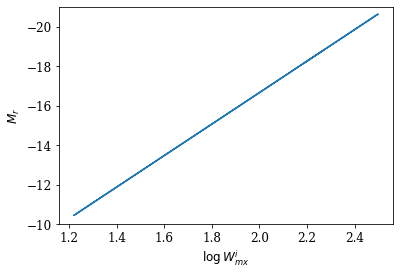

In [11]:
cut = [CF_table['logWmxi'] < 2.5]
logW = np.asarray(CF_table['logWmxi'][cut])
M, M_err = abs_mag(logW)
plt.plot(logW, M)
# plt.axhline(-18, color='k', ls=':')
plt.ylim(-10, -21)
plt.xlabel('$\log{W^i_{mx}}$')
plt.ylabel('$M_r$')
plt.show()

In [12]:
# logW_matched = []
# PGC_CF = []
# for idx in range(len(CF_table)):
#     if CF_table['PGC'][idx] == 

cut = [idx for idx in range(len(CF_table)) if CF_table['PGC'][idx] in pgc]
logW_matched = CF_table['logWmxi'][cut]
cut2 = [logW_matched < 2.5]
logW_matched = logW_matched[cut2]

/tmp/ipykernel_6354/458186382.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  logW_matched = logW_matched[cut2]


In [13]:
cut1 = [idx for idx in range(len(CF_table)) if CF_table['PGC'][idx] in pgc]
CF_PGC = CF_table['PGC'][cut1]
CF_PGC2 = CF_PGC[cut2]
# CF_PGC2

/tmp/ipykernel_6354/130563770.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  CF_PGC2 = CF_PGC[cut2]


In [14]:
CF_abs_mag, CF_abs_mag_err = abs_mag(logW_matched)

## Find absolute magnitude from Coma TFR

The Coma calibration yields the slope of the TFR, while the y-intercept comes from fitting a line with this slope to objects with known distance moduli. Therefore the TFR is:
$$M=-4.5498 -6.8241\log{v_{\text{max}}}$$
where $v_{\text{max}}$ is the rotational velocity of the galaxy at 0.33$R$ in km/s. 

In [15]:
y_int = -4.5499
y_int_err = 0.09628
slope = -6.8241
slope_err = 0.86871

cut = [idx for idx in range(len(galaxy_table)) if galaxy_table['PGC'][idx] in CF_PGC2]
logvmax = galaxy_table['LOG_VMAX'][cut]
M = y_int + slope * logvmax
M_err = []
for i, dlogv in enumerate(galaxy_table['LOG_VMAX_ERR'][cut]):
    M_err.append(np.sqrt(y_int_err**2 + slope**2 * dlogv**2 + slope_err**2 * logvmax[i]**2))
SGA_PGC = galaxy_table['PGC'][cut]

## Join data from both surevys into a single table

In [16]:
SGA_tab = Table([SGA_PGC, M, M_err],
                names = ['PGC', 'M_SGA', 'M_ERR_SGA'])
SGA_tab

PGC,M_SGA,M_ERR_SGA
int64,float64,float64
55821,-18.526347339630917,1.782861376131644
61276,-19.486929183246797,1.963956983915719
44370,-16.995267886213856,1.6019851290945415
49791,-18.341336737097805,1.8020639473313795
2057435,-20.13054213678993,1.9860490213634334
49887,-15.505632812176906,1.4096018376916044
90978,-17.966822190888003,1.711455111667006
52178,-13.964760845058624,1.4932819730797557
53779,-13.964277139986848,2.348847803027864


In [17]:
CF_tab = Table([CF_PGC2, CF_abs_mag, CF_abs_mag_err],
               names = ['PGC', 'M_CF4', 'M_ERR_CF4'])
CF_tab

PGC,M_CF4,M_ERR_CF4
,dex(km / s),dex(km / s)
int64,float64,float64
36743,-19.018199999999997,0.3146628711812056
37807,-20.252,0.3338296721383527
38815,-18.7794,0.31096752643965897
38864,-19.90176,0.3283768085599225
43840,-20.51468,0.3379251161130229
44147,-19.694799999999997,0.32515897650226416
44370,-18.962479999999996,0.3138001810069586
44416,-20.0928,0.3313499811377692


In [18]:
mastertab = join(CF_tab, SGA_tab, join_type = 'inner')
mastertab.remove_row(34)
mastertab

PGC,M_CF4,M_ERR_CF4,M_SGA,M_ERR_SGA
,dex(km / s),dex(km / s),,
int64,float64,float64,float64,float64
36743,-19.018199999999997,0.3146628711812056,-18.1242804710092,1.7320622806712136
37807,-20.252,0.3338296721383527,-19.88417293125574,1.9545720917141947
38815,-18.7794,0.31096752643965897,-16.952560955112432,1.6103942459330922
38864,-19.90176,0.3283768085599225,-17.720676352007896,1.6840672518126447
43840,-20.51468,0.3379251161130229,-19.255907027625394,1.874753329914606
44147,-19.694799999999997,0.32515897650226416,-18.62492608196239,1.7962381365972917
44370,-18.962479999999996,0.3138001810069586,-16.995267886213856,1.6019851290945415
44416,-20.0928,0.3313499811377692,-19.220071619423862,1.8702259751668562


In [19]:
mastertab.write('cache/TF_Coma_CF4_comparison.fits', format = 'fits')

OSError: File cache/TF_Coma_CF4_comparison.fits already exists. If you mean to replace it then use the argument "overwrite=True".

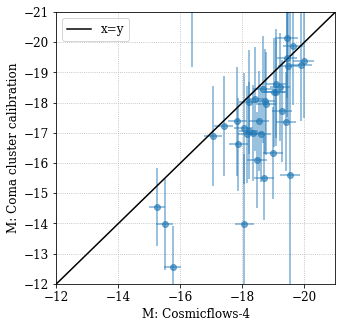

In [23]:
fig, ax = plt.subplots(figsize = (5,5))
ax.errorbar(mastertab['M_CF4']-5*np.log10(0.751), mastertab['M_SGA'], 
             xerr = mastertab['M_ERR_CF4'], yerr = mastertab['M_ERR_SGA'], fmt='o', alpha = 0.6)
# plt.plot(mastertab['M_CF4'], mastertab['M_SGA'], 'o')

ax.set(xlabel = 'M: Cosmicflows-4',
       ylabel = 'M: Coma cluster calibration',
       xlim = (-12, -21),
       ylim = (-12, -21))
ax.plot([-12, -21], [-12, -21], 'k', label = 'x=y')
ax.legend()
ax.grid(ls = ':')
# plt.figure(figsize=(5,5))
# fig.savefig('cache/Cosmicflows4-Coma_comparison_04_14_2022.png', bbox_inches='tight')

In [24]:
np.where(mastertab['M_SGA']==np.amax(mastertab['M_SGA']))

(array([32]),)